# Holo2: Cookbook - Using OpenAI Client to invoke Holo2 for a localization task

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/hcompai/hai-cookbook/blob/main/holo2)
[![GitHub](https://img.shields.io/badge/Holo_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/hcompai/hai-cookbook)
[![Hugging Face](https://img.shields.io/badge/H_Company-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany)

Holo2 is a **state-of-the-art Action Vision-Language Model** developed by [H Company](https://www.hcompany.ai/). Fine-tuned from the [Qwen3-VL Thinking Family](https://huggingface.co/collections/Qwen/qwen3-vl), it excels at **UI element localization** and **UI navigation** across environments (computer, web, mobile).

This quickstart demonstrates the core grounding capability: **(screenshot + task) → click coordinates**.

## Contents

1. [Install required python dependencies](#1-install-required-python-dependencies)
2. [Prepare the Input Payload](#2-prepare-the-input-payload)
3. [Invoke Holo2 via API](#3-invoke-holo2-via-API)


## 1. Install required python dependencies

In [ ]:
!python -m pip install -q -U openai pillow pydantic python-dotenv rich

In [2]:
from typing import Any, Literal, TypeAlias

from PIL import Image
from pydantic import BaseModel, Field
import pathlib as pl
import sys
from IPython.display import display

In [3]:
# Add directory to the Python path to import utils package
project_root_dir = pl.Path.cwd().resolve().parents[1]
sys.path.append(str(project_root_dir))

# Get cursor .png path
cursor_img_path = project_root_dir / "data" / "cursor_image_red.png"

## 2. Prepare the Input Payload

Holo2 is hosted on H Company's inference platform and is compatible with the OpenAI Chat Completions API protocol.

In this example, Holo2 is prompted to identify the correct location to click in order to successfully select a date on the calendar.

**Important**: The input image must be resized using Qwen’s `smart_resize` method. This is crucial because the served model performs its own internal resizing, which can alter the original image dimensions and lead to inaccurate or misaligned coordinate predictions from the model.

In [ ]:
from utils.image import convert_image_to_base64_url

class ClickCoordinates(BaseModel):
    x: int = Field(ge=0, le=1000, description="The x coordinate, normalized between 0 and 1000.")
    y: int = Field(ge=0, le=1000, description="The y coordinate, normalized between 0 and 1000.")

ChatMessage: TypeAlias = dict[str, Any]


def build_messages(task: str, image: Image.Image, image_format: str) -> list[ChatMessage]:
    """Create the prompt structure for navigation task"""
    prompt = f"""Localize an element on the GUI image according to the provided target and output a click position.
     * You must output a valid JSON following the format: {ClickCoordinates.model_json_schema()}
     Your target is:"""

    image_url = convert_image_to_base64_url(image=image, format=image_format)

    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url", 
                    "image_url": {
                        "url": image_url,
                    },
                },
                {"type": "text", "text": f"{prompt}\n{task}"},
            ],
        },
    ]

Prepare the input request

In [5]:
# Prepare inference request
from utils.image import smart_resize

# Load image
image_path = project_root_dir / "data" / "calendar_example.jpg"
image = Image.open(image_path)

# Resize the image so that predicted absolute coordinates match the size of the image.
resized_height, resized_width = smart_resize(height=image.height, width=image.width)
image = image.resize(size=(resized_width, resized_height), resample=None)

task = "Select July 14th as the check-out date"

## 3. Invoke Holo2 via API

### Set up your API key

You can provide the API key in two ways:
	•	Directly by assigning it to the API_KEY variable.
	•	Indirectly by adding it to a .env file under the variable name HAI_API_KEY.

If no API key is found, an error will be raised.

In [ ]:
API_KEY = ""

In [7]:
if not API_KEY:
    import os
    if os.path.exists("../../.env"):
        from dotenv import load_dotenv
        # By default, looks for a .env file in the current directory or parents
        load_dotenv(override=True)
        API_KEY = os.getenv("HAI_API_KEY")
    else:
        !cp ../../.env.example ../../.env
        assert False, "Please fill in the API key in the .env file"


assert API_KEY, "API_KEY is not set, please set the HAI_API_KEY environment variable or fill in the API_KEY variable"

### Set up model

In [ ]:
MODEL_NAME = "<model-name>"
API_BASE_URL = "<api-base-url>"
BASE_URL = f"{API_BASE_URL}/{MODEL_NAME}"

### Invoke model

ClickAbsoluteAction(action='click_absolute', x=342, y=345)

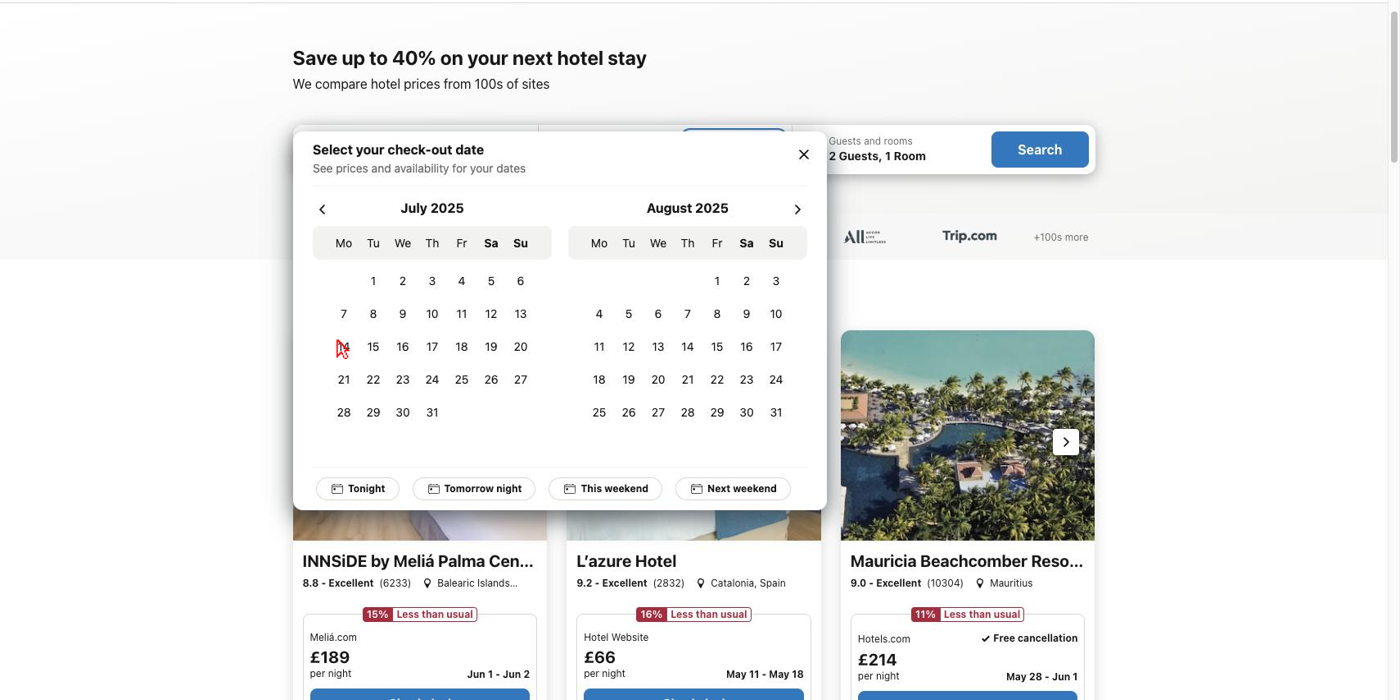

In [ ]:
from utils.image import draw_image_with_click
from openai import OpenAI
import rich
import json

client = OpenAI(
    base_url=BASE_URL,
    api_key=API_KEY
)

chat_completion = client.chat.completions.create(
    model=MODEL_NAME,
    messages=build_messages(
        task=task,
        image=image,
        image_format="JPEG",
    ),
    extra_body={
        "guided_json": ClickCoordinates.model_json_schema(),
        "chat_template_kwargs": {"thinking": False}
    },
    temperature=0,
)


click = ClickCoordinates(**json.loads(chat_completion.choices[0].message.content))
rich.print(click)

display(draw_image_with_click(image, int(click.x / 1000 * image.width), int(click.y / 1000 * image.height), cursor_img_path))